In [1]:
!pip install -q torch transformers open_clip_torch accelerate bitsandbytes langchain langchain-community langchain-experimental sentence-transformers faiss-gpu openpyxl pacmap datasets langchain-community ragatouille
!pip install matplotlib
!pip install plotly

In [1]:
import os
import numpy as np
import pandas as pd
from pprint import pprint
from pathlib import Path
from typing import Optional, List, Tuple
from tqdm.notebook import tqdm

import datasets
from datasets import Dataset
import matplotlib.pyplot as plt
from PIL import Image

import torch
from sentence_transformers import SentenceTransformer
from transformers import pipeline, Pipeline
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

pd.set_option(
    "display.max_colwidth", None
)  # This will be helpful when visualizing retriever outputs

# load dataset

In [2]:
df = pd.read_csv("llava_outputs_with_responses.csv")

In [3]:
df

,image_path,output,scene_graph,gpt_prompt,gpt_response
0,/mnt/vol0/datasets/rosbag2_navigation_for_graph_21_feb_2024/rgb_images/00000.jpg,"In the image, I see a whiteboard mounted on a wall with various diagrams and equations written on it. The whiteboard is positioned to the left of the frame, and it appears to be the main focus of the image. To the right of the whiteboard, there is a black trash can. The trash can is standing on the floor, and it is positioned in front of a white cabinet. The cabinet is closed and appears to be of a standard design, likely used for storage. The floor beneath these objects is a dark color, providing a contrast to the whiteboard and cabinet. The overall scene suggests an office or classroom setting.","{'trash_can_1': [[728, 531, 816, 658]], 'wall_socket_1': [[546, 511, 639, 542]], 'wall_socket_2': [[0, 494, 31, 522]], 'cabinet_1': [[1137, 237, 1280, 681]], 'hinge_1': [[863, 215, 944, 243]], 'tricycle_1': [[0, 538, 209, 623]], 'cabinet_2': [[854, 223, 1280, 674]], 'knob_1': [[1128, 250, 1141, 262]], 'hinge_2': [[862, 262, 869, 340]], 'thermostat_1': [[23, 125, 49, 152]], 'refrigerator_1': [[855, 225, 1157, 673]], 'wheel_1': [[143, 553, 210, 622]], 'bulletin_board_1': [[60, 0, 816, 343]], 'knob_2': [[1175, 252, 1190, 275]]}","You are given with a JSON-like description of the scene. This description is a dictionary where the key is the class name and ID of the object, and value is the bounding box of the object in the source image. Based on this dictionary, you are asked to generate a graph-like description of the scene. You need to summarize spatial relationships between the objects on the scene. Be brief and precise, don't give introductory and conclusion words. Focus on the meaningful part of the response. Also ignore following classes: person, lightbulb. \n{'trash_can_1': [[728, 531, 816, 658]], 'wall_socket_1': [[546, 511, 639, 542]], 'wall_socket_2': [[0, 494, 31, 522]], 'cabinet_1': [[1137, 237, 1280, 681]], 'hinge_1': [[863, 215, 944, 243]], 'tricycle_1': [[0, 538, 209, 623]], 'cabinet_2': [[854, 223, 1280, 674]], 'knob_1': [[1128, 250, 1141, 262]], 'hinge_2': [[862, 262, 869, 340]], 'thermostat_1': [[23, 125, 49, 152]], 'refrigerator_1': [[855, 225, 1157, 673]], 'wheel_1': [[143, 553, 210, 622]], 'bulletin_board_1': [[60, 0, 816, 343]], 'knob_2': [[1175, 252, 1190, 275]]}","- Trash can is below the bulletin board and to the right of the tricycle.\n- Wall socket 1 is to the left of the trash can and below the bulletin board.\n- Wall socket 2 is to the left of the tricycle and below the bulletin board.\n- Cabinet 1 is to the right of the refrigerator and above the trash can.\n- Cabinet 2 is to the right of the refrigerator and above the trash can.\n- Hinge 1 is above the refrigerator and to the left of cabinet 1.\n- Tricycle is to the left of the trash can and below the bulletin board.\n- Refrigerator is to the left of cabinet 1 and cabinet 2.\n- Wheel is part of the tricycle and below the bulletin board.\n- Bulletin board is above the trash can, wall sockets, and tricycle.\n- Knob 1 is on cabinet 1.\n- Hinge 2 is on cabinet 2 and above the refrigerator.\n- Thermostat is above the tricycle and to the left of the bulletin board.\n- Knob 2 is on cabinet 2."
1,/mnt/vol0/datasets/rosbag2_navigation_for_graph_21_feb_2024/rgb_images/00252.jpg,"The image shows an interior space that appears to be a corridor or hallway. The floor is covered with a dark gray carpet, and the walls are painted white. On the left side of the image, there is a white door with a black handle, which is partially visible. The door is closed.\n\nIn the background, there is a glass partition that separates the hallway from another room. The glass is transparent, allowing a view into the room beyond. The room beyond the glass partition has a modern design with a white ceiling and a large window that lets in natural light. The window is reflective, suggesting it might be a glass wall or a large glass panel.\n\nOn the right si

In [4]:
from pathlib import Path

# Функция для извлечения stem из пути
def extract_stem(image_path):
    return Path(image_path).stem

# Применение функции ко всей колонке и создание новой колонки 'image_id'
df['image_id'] = df['image_path'].apply(extract_stem)


In [5]:
df['combined'] = 'Image ID is ' + df['image_id'] + '.\nHere is the short description of it: \n' + df['output'] + "\nHere is the scene graph of it: \n" + df['gpt_response']

In [6]:
ddf = df['combined']

In [7]:
ddf.loc[15]

'Image ID is 00627.\nHere is the short description of it: \nThe image shows an interior space that appears to be a lobby or waiting area. In the foreground, there is a large, white, rectangular box with text on it, which could be a sign or a piece of equipment. To the right of this box, there is a white couch with a curved backrest. The couch is positioned against a wall that has a red fire extinguisher mounted on it.\n\nIn the background, there is a glass partition with a patterned design, through which a doorway is visible. The doorway leads to another room with a white door and a circular window. The floor is carpeted, and there are several white squares on the carpet, which could be markers or indicators for some purpose.\n\nThe lighting in the room is bright, and the overall color scheme is neutral, with white and gray tones dominating the space. There are no people visible in the image. The style of the image is a standard, unfiltered photograph with no artistic effects applied.\

100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 746.00it/s]


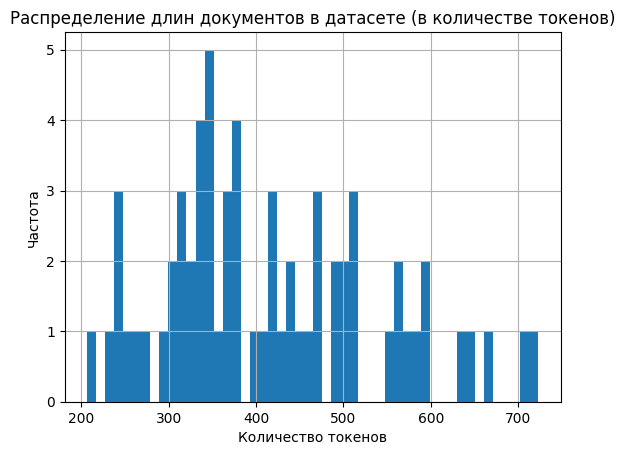

In [8]:
import pandas as pd
from transformers import AutoTokenizer
from tqdm import tqdm
import matplotlib.pyplot as plt

# Инициализируйте токенайзер
MODEL_NAME = 'thenlper/gte-small'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Вычислите длины документов в токенах
lengths = [len(tokenizer.encode(text)) for text in tqdm(ddf)]

# Постройте распределение длин документов
fig = pd.Series(lengths).hist(bins=50)
plt.title("Распределение длин документов в датасете (в количестве токенов)")
plt.xlabel("Количество токенов")
plt.ylabel("Частота")
plt.show()


In [9]:
# Создаем документы без разбиение на чанки, так как теряется контекст
from langchain.docstore.document import Document as LangchainDocument

docs_processed = [LangchainDocument(page_content=text) for text in ddf]

In [10]:
# MARKDOWN_SEPARATORS = [
#     "\n#{1,6} ",
#     "```\n",
#     "\n\\*\\*\\*+\n",
#     "\n---+\n",
#     "\n___+\n",
#     "\n\n",
#     "\n",
#     " ",
#     "",
# ]

In [11]:
# from langchain.text_splitter import RecursiveCharacterTextSplitter
# from langchain.docstore.document import Document as LangchainDocument

# text_splitter = RecursiveCharacterTextSplitter(
#     chunk_size=1000,
#     chunk_overlap=100,
#     add_start_index=True,
#     strip_whitespace=True,
#     separators=MARKDOWN_SEPARATORS,
# )

# docs_processed = []
# for text in ddf:
#     doc = LangchainDocument(page_content=text)
#     docs_processed += text_splitter.split_documents([doc])


In [12]:
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy
from transformers import AutoTokenizer

EMBEDDING_MODEL_NAME = "thenlper/gte-small"


embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
)

KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

/tmp/ipykernel_102104/804290893.py:9: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(


In [71]:
# Embed a user query in the same space
user_query = "Find me a place, where I can find a TV. Give me an image ID to it. Also write a reasoning, why you choose this image"
query_vector = embedding_model.embed_query(user_query)

In [72]:
import pacmap
import numpy as np
import plotly.express as px

embedding_projector = pacmap.PaCMAP(
    n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, random_state=1
)

embeddings_2d = [
    list(KNOWLEDGE_VECTOR_DATABASE.index.reconstruct_n(idx, 1)[0])
    for idx in range(len(docs_processed))
] + [query_vector]

# Fit the data (the index of transformed data corresponds to the index of the original data)
documents_projected = embedding_projector.fit_transform(
    np.array(embeddings_2d), init="pca"
)

/home/altair/miniconda3/envs/rag/lib/python3.10/site-packages/pacmap/pacmap.py:822: UserWarning:




In [37]:
docs_processed[0]

Document(metadata={}, page_content='Image ID is 00000.\nHere is the short description of it: \nIn the image, I see a whiteboard mounted on a wall with various diagrams and equations written on it. The whiteboard is positioned to the left of the frame, and it appears to be the main focus of the image. To the right of the whiteboard, there is a black trash can. The trash can is standing on the floor, and it is positioned in front of a white cabinet. The cabinet is closed and appears to be of a standard design, likely used for storage. The floor beneath these objects is a dark color, providing a contrast to the whiteboard and cabinet. The overall scene suggests an office or classroom setting.\nHere is the scene graph of it: \n- Trash can is below the bulletin board and to the right of the tricycle.\n- Wall socket 1 is to the left of the trash can and below the bulletin board.\n- Wall socket 2 is to the left of the tricycle and below the bulletin board.\n- Cabinet 1 is to the right of the 

In [38]:
docs_processed

[Document(metadata={}, page_content='Image ID is 00000.\nHere is the short description of it: \nIn the image, I see a whiteboard mounted on a wall with various diagrams and equations written on it. The whiteboard is positioned to the left of the frame, and it appears to be the main focus of the image. To the right of the whiteboard, there is a black trash can. The trash can is standing on the floor, and it is positioned in front of a white cabinet. The cabinet is closed and appears to be of a standard design, likely used for storage. The floor beneath these objects is a dark color, providing a contrast to the whiteboard and cabinet. The overall scene suggests an office or classroom setting.\nHere is the scene graph of it: \n- Trash can is below the bulletin board and to the right of the tricycle.\n- Wall socket 1 is to the left of the trash can and below the bulletin board.\n- Wall socket 2 is to the left of the tricycle and below the bulletin board.\n- Cabinet 1 is to the right of the

In [39]:
%matplotlib notebook

In [73]:
df = pd.DataFrame.from_dict(
    [
        {
            "x": documents_projected[i, 0],
            "y": documents_projected[i, 1],
            #"source": docs_processed[i].metadata["source"].split("/")[1],
            "extract": docs_processed[i].page_content[:100] + "...",
            "symbol": "circle",
            "size_col": 4,
        }
        for i in range(len(docs_processed))
    ]
    + [
        {
            "x": documents_projected[-1, 0],
            "y": documents_projected[-1, 1],
            "source": "User query",
            "extract": user_query,
            "size_col": 100,
            "symbol": "star",
        }
    ]
)

# Visualize the embedding
fig = px.scatter(
    df,
    x="x",
    y="y",
    color="source",
    hover_data="extract",
    size="size_col",
    symbol="symbol",
    color_discrete_map={"User query": "black"},
    width=1000,
    height=700,
)
fig.update_traces(
    marker=dict(opacity=1, line=dict(width=0, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
fig.update_layout(
    legend_title_text="<b>Chunk source</b>",
    title="<b>2D Projection of Chunk Embeddings via PaCMAP</b>",
)
fig.show()

In [74]:
print(f"\nStarting retrieval for {user_query=}...")
retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=5)
print(
    "\n==================================Top document=================================="
)
print(retrieved_docs[0].page_content)
print("==================================Metadata==================================")
print(retrieved_docs[0].metadata)


Starting retrieval for user_query='Find me a place, where I can find a TV. Give me an image ID to it. Also write a reasoning, why you choose this image'...

==================================Top document==================================
Image ID is 00813.
Here is the short description of it: 
The image shows an interior space that appears to be a room with a high ceiling and large windows. The floor is a light color, possibly concrete or a similar material, and there are no visible people in the room.

In the foreground, there is a table with a black frame and a white top, which is positioned in the center of the room. To the right of the table, there is a television mounted on the wall, displaying a blue screen with some text and graphics that are not clearly legible.

In the background, there is a door with a glass panel, and to the left of the door, there is a whiteboard with a circular design on it. The door is closed, and the whiteboard is mounted on the wall.

On the left side 

In [75]:
len(retrieved_docs)

5

In [76]:
for doc_top_i, doc in enumerate(retrieved_docs):
    print(
    f"\n================================== Document #{doc_top_i} =================================="
    )
    print(doc.page_content)
    print("====================================================================")


================================== Document #0 ==================================
Image ID is 00813.
Here is the short description of it: 
The image shows an interior space that appears to be a room with a high ceiling and large windows. The floor is a light color, possibly concrete or a similar material, and there are no visible people in the room.

In the foreground, there is a table with a black frame and a white top, which is positioned in the center of the room. To the right of the table, there is a television mounted on the wall, displaying a blue screen with some text and graphics that are not clearly legible.

In the background, there is a door with a glass panel, and to the left of the door, there is a whiteboard with a circular design on it. The door is closed, and the whiteboard is mounted on the wall.

On the left side of the room, there is a large window with multiple panes, and the window is partially obscured by a black metal frame. The window is not fully visible, but 

In [55]:
from huggingface_hub import notebook_login

notebook_login()

In [87]:
READER_MODEL_NAME = "meta-llama/Llama-2-13b-chat-hf"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)
model = AutoModelForCausalLM.from_pretrained(
    READER_MODEL_NAME, quantization_config=bnb_config
)
tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)

READER_LLM = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500,
)

config.json:   0%|          | 0.00/587 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/33.4k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/9.90G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/6.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [88]:
simple_answer = READER_LLM(user_query)
print(simple_answer[0]['generated_text'])

 and not another one.

I want to watch the TV show "The Big Bang Theory" in English.

Please provide me with the image ID and the reasoning for your choice.


In [89]:
prompt_in_chat_format = [
    {
        "role": "system",
        "content": """Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.""",
    },
    {
        "role": "user",
        "content": """Context:
{context}
---
Now here is the question you need to answer.

Question: {question}""",
    },
]
RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(
    prompt_in_chat_format, tokenize=False, add_generation_prompt=True
)
print(RAG_PROMPT_TEMPLATE)

<s>[INST] <<SYS>>
Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.
<</SYS>>

Context:
{context}
---
Now here is the question you need to answer.

Question: {question} [/INST]


In [90]:
retrieved_docs_text = [
    doc.page_content for doc in retrieved_docs
]
# We only need the text of the documents

context = "\nExtracted documents:\n"
context += "".join(
    [f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)]
)

final_prompt = RAG_PROMPT_TEMPLATE.format(
    question=user_query, context=context
)

# Redact an answer
answer = READER_LLM(final_prompt)[0]["generated_text"]
print(answer)

  Based on the given context, I would suggest looking for a TV in Document 1, specifically Image ID 00792.

My reasoning for choosing this image is as follows:

1. The image shows a well-lit room with a large, white, rectangular object that could be a piece of art or a sculpture placed on a stand, which is elevated off the floor. This object resembles a TV stand or a media console, and it is likely that a TV is mounted on it.
2. The image also shows a long table with a white tablecloth, which could be a dining table or a conference table. TVs are often placed on such tables in meeting rooms or living rooms.
3. Additionally, the image depicts a modern and minimalist aesthetic, which is consistent with the design of many contemporary TVs.

Therefore, based on these observations, I believe that Image ID 00792 in Document 1 is a good candidate for finding a TV.


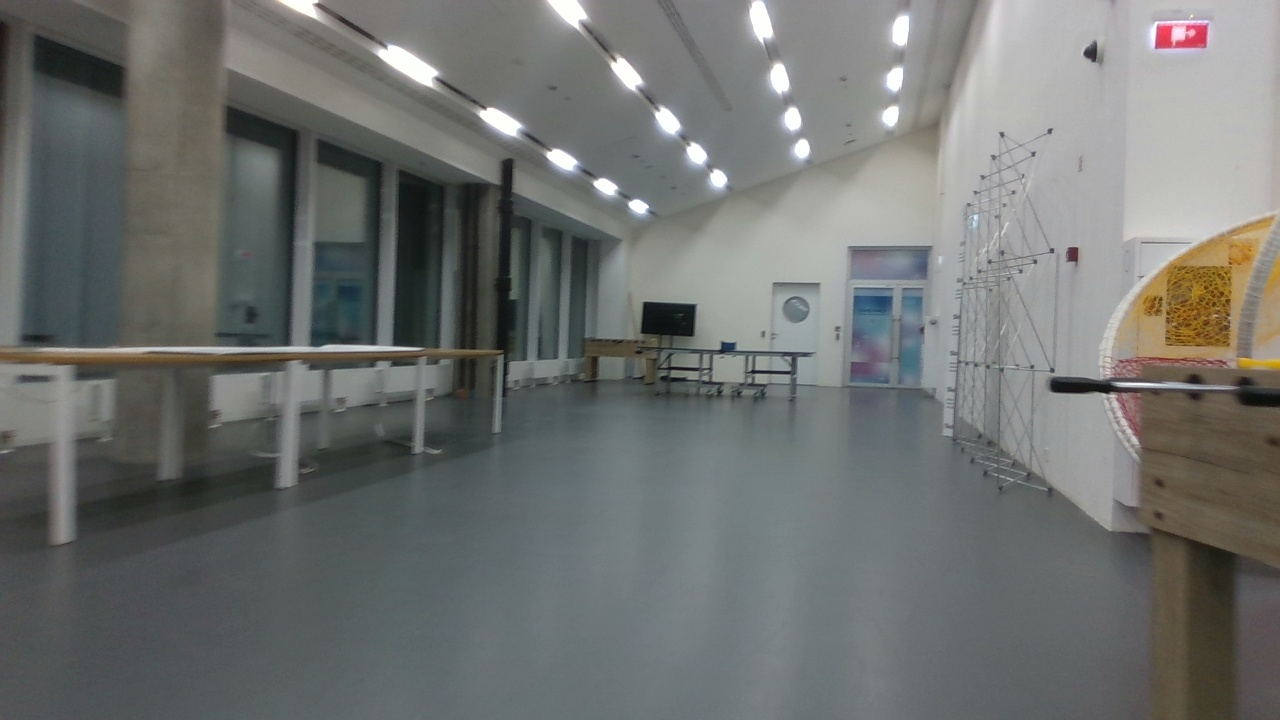

In [91]:
import PIL

image = PIL.Image.open("/mnt/vol0/datasets/rosbag2_navigation_for_graph_21_feb_2024/rgb_images/00792.jpg")
image.show()